In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
! cp drive/MyDrive/DMG/Assignment4/banking.csv .
! cp drive/MyDrive/DMG/Assignment4/fetal_health_1.csv .
! cp drive/MyDrive/DMG/Assignment4/fetal_health_2.csv .
! cp drive/MyDrive/DMG/Assignment4/risk_factors_cervical_cancer.csv .

In [ ]:
import pandas as pd
import numpy as np
dataset1 = pd.read_csv('risk_factors_cervical_cancer.csv')
dataset2_p1 = pd.read_csv('fetal_health_1.csv')
dataset2_p2 = pd.read_csv('fetal_health_2.csv')
dataset2 = pd.concat([dataset2_p1, dataset2_p2])
dataset3 = pd.read_csv('banking.csv')

In [ ]:
dataset2["fetal_health"].value_counts()

1    1655
2     295
3     176
Name: fetal_health, dtype: int64

In [ ]:
#data cleaning
# Replacing the null values of each column with the mean value of the column
for column in dataset1.columns:
  dataset1[column] = dataset1[column].replace('?', np.nan)
dataset1 = dataset1.astype(float)
for column in dataset1.columns:
  reqMean = dataset1[column].mean()
  dataset1[column] = dataset1[column].replace(np.nan,reqMean)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
def split_and_normalise(dataframe,target_col):
  data_x = np.array(dataframe.loc[:,dataframe.columns != target_col])
  data_y = np.array(dataframe.loc[:,dataframe.columns == target_col])
  data_y = data_y.astype(np.int64)
  train_x, test_x, train_y, test_y = train_test_split(data_x,data_y,test_size=0.20,random_state = 56,stratify=data_y)
  train_y = train_y.reshape(train_y.shape[0])
  test_y = test_y.reshape(test_y.shape[0])
  scaler = StandardScaler().fit(train_x)
  train_x_scaled = scaler.transform(train_x)
  test_x_scaled = scaler.transform(test_x)
  return train_x_scaled,train_y,test_x_scaled,test_y

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve,auc
import matplotlib.pyplot as plt

def train_5_fold_validate(train_x,train_y,model):
  folds_genarator = StratifiedKFold(n_splits = 5)
  result_arr = []
  tpr_arr = []
  fpr_arr = []
  for train_index, test_index in folds_genarator.split(train_x, train_y):
    train_data_x_5_fold = train_x[train_index]
    train_data_y_5_fold = train_y[train_index]
    test_data_x_5_fold = train_x[test_index]
    test_data_y_5_fold = train_y[test_index]
    model.fit(train_data_x_5_fold,train_data_y_5_fold)
    predicted_labels = model.predict(test_data_x_5_fold)
    cf_mat = confusion_matrix(test_data_y_5_fold, predicted_labels)
    true_negative = cf_mat[0][0]
    false_positive = cf_mat[0][1]
    false_negative = cf_mat[1][0]
    true_positive = cf_mat[1][1]
    accuracy = (true_positive + true_negative)/(true_negative + false_positive + false_negative + true_positive)
    precision = true_positive/(false_positive + true_positive)
    recall = true_positive/(false_negative + true_positive)
    f1_score_val = (2 * recall * precision)/(recall + precision)
    fpr,tpr,rand = roc_curve(test_data_y_5_fold, model.predict_proba(test_data_x_5_fold)[:,1])
    fpr_arr.extend(fpr)
    tpr_arr.extend(tpr)
    result_arr.append([precision,recall,f1_score_val,accuracy])
  result_arr = np.array(result_arr)
  result_mean_arr = np.mean(result_arr, axis=0)
  print("Average scores across the 5 folds Accuracy: {}, Precison: {}, Recall : {} , F1_score:{} ".format(result_mean_arr[3],result_mean_arr[0],result_mean_arr[1],result_mean_arr[2]))
  roc_auc = auc(fpr,tpr)
  plt.plot(fpr, tpr,label = roc_auc)
  plt.title("AUC_ROC curve")
  return model

In [ ]:
def plot_decision_boundary(data_x, data_y,model):

    # Create a meshgrid for visualization
    h = .02  # Step size in the mesh
    x_min, x_max = data_x[:, 0].min() - 1, data_x[:, 0].max() + 1
    y_min, y_max = data_x[:, 1].min() - 1, data_x[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Predict the labels for each point in the meshgrid
    meshgrid_data = np.c_[xx.ravel(), yy.ravel()]
    model.fit(data_x,data_y)
    Z = model.predict(meshgrid_data)
    Z = Z.reshape(xx.shape)

    # Plot the decision boundary
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)

    # Scatter plot of data points
    plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, edgecolors='k', cmap=plt.cm.coolwarm)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Decision Boundary Visualization')
    plt.show()

In [ ]:
def test(test_x,test_y,model):
  predicted_labels = model.predict(test_x)
  cf_mat = confusion_matrix(test_y, predicted_labels)
  true_negative = cf_mat[0][0]
  false_positive = cf_mat[0][1]
  false_negative = cf_mat[1][0]
  true_positive = cf_mat[1][1]
  accuracy = (true_positive + true_negative)/(true_negative + false_positive + false_negative + true_positive)
  precision = true_positive/(false_positive + true_positive)
  recall = true_positive/(false_negative + true_positive)
  f1_score_val = (2 * recall * precision)/(recall + precision)
  fpr,tpr,rand = roc_curve(test_y, model.predict_proba(test_x)[:,1])
  print("Scores on the test data Accuracy: {} Precison: {}, Recall : {} , F1_score:{} ".format(accuracy,precision,recall,f1_score_val))
  roc_auc = auc(fpr,tpr)
  plt.plot(fpr, tpr,label = roc_auc)
  plt.title("AUC_ROC curve")



In [ ]:
#Only for dataset2
def train_5_fold_validate_2(train_x,train_y,train_y_bin,model,bin_model):
  folds_genarator = StratifiedKFold(n_splits = 5)
  result_arr = []
  tpr_arr = []
  fpr_arr = []
  for train_index, test_index in folds_genarator.split(train_x, train_y):
    train_data_x_5_fold = train_x[train_index]
    train_data_y_5_fold = train_y[train_index]
    test_data_x_5_fold = train_x[test_index]
    test_data_y_5_fold = train_y[test_index]
    model.fit(train_data_x_5_fold,train_data_y_5_fold)
    predicted_labels = model.predict(test_data_x_5_fold)
    cf_mat = confusion_matrix(test_data_y_5_fold, predicted_labels)
    true_negative = cf_mat[0][0]
    false_positive = cf_mat[0][1]
    false_negative = cf_mat[1][0]
    true_positive = cf_mat[1][1]
    accuracy = (true_positive + true_negative)/(true_negative + false_positive + false_negative + true_positive)
    precision = true_positive/(false_positive + true_positive)
    recall = true_positive/(false_negative + true_positive)
    f1_score_val = (2 * recall * precision)/(recall + precision)
    result_arr.append([precision,recall,f1_score_val,accuracy])
  for train_index, test_index in folds_genarator.split(train_x, train_y_bin):
    train_data_x_5_fold = train_x[train_index]
    train_data_y_5_fold = train_y_bin[train_index]
    test_data_x_5_fold = train_x[test_index]
    test_data_y_5_fold = train_y_bin[test_index]
    bin_model.fit(train_data_x_5_fold,train_data_y_5_fold)
    fpr,tpr,rand = roc_curve(test_data_y_5_fold, bin_model.predict_proba(test_data_x_5_fold)[:,1])
    fpr_arr.extend(fpr)
    tpr_arr.extend(tpr)

  result_arr = np.array(result_arr)
  result_mean_arr = np.mean(result_arr, axis=0)
  print("Average scores across the 5 folds Accuracy: {}, Precison: {}, Recall : {} , F1_score:{} ".format(result_mean_arr[3],result_mean_arr[0],result_mean_arr[1],result_mean_arr[2]))
  roc_auc = auc(fpr,tpr)
  plt.plot(fpr, tpr,label = roc_auc)
  plt.title("AUC_ROC curve")
  return model,bin_model

In [ ]:
#Only for dataset2
def test_2(test_x,test_y,test_y_bin,model,bin_model):

  predicted_labels = model.predict(test_x)
  cf_mat = confusion_matrix(test_y, predicted_labels)
  true_negative = cf_mat[0][0]
  false_positive = cf_mat[0][1]
  false_negative = cf_mat[1][0]
  true_positive = cf_mat[1][1]
  accuracy = (true_positive + true_negative)/(true_negative + false_positive + false_negative + true_positive)
  precision = true_positive/(false_positive + true_positive)
  recall = true_positive/(false_negative + true_positive)
  f1_score_val = (2 * recall * precision)/(recall + precision)
  fpr,tpr,rand = roc_curve(test_y_bin, bin_model.predict_proba(test_x)[:,1])
  print("Scores on the test data Accuracy: {} Precison: {}, Recall : {} , F1_score:{} ".format(accuracy,precision,recall,f1_score_val))
  roc_auc = auc(fpr,tpr)
  plt.plot(fpr, tpr,label = roc_auc)
  plt.title("AUC_ROC curve")


In [ ]:
!pip install xgboost

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost
from sklearn.model_selection import GridSearchCV

In [ ]:
train_x, train_y, test_x, test_y = split_and_normalise(dataset1,"Biopsy")

Average scores across the 5 folds Accuracy: 0.948979160055009, Precison: 0.7416666666666666, Recall : 0.3666666666666667 , F1_score:0.46363440481087537 


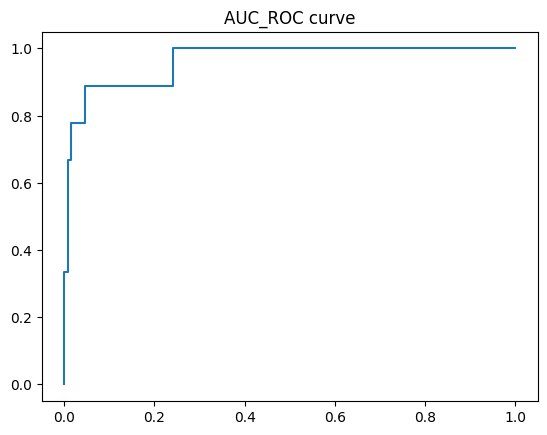

In [ ]:
#train
param_grid = [{'criterion':["gini", "entropy"],'max_depth':[6,10,14,18],"n_estimators":[80,120,140]}]
classifification_model_obj = GridSearchCV(estimator = RandomForestClassifier(random_state = 62),param_grid = param_grid,scoring = 'accuracy',refit=True).fit(train_x,train_y)
classifification_model_not_fitted = classifification_model_obj.best_estimator_
rf_model = classifification_model_obj.best_estimator_
rf_model = train_5_fold_validate(train_x,train_y,rf_model)


Scores on the test data Accuracy: 0.9476744186046512 Precison: 0.75, Recall : 0.2727272727272727 , F1_score:0.39999999999999997 


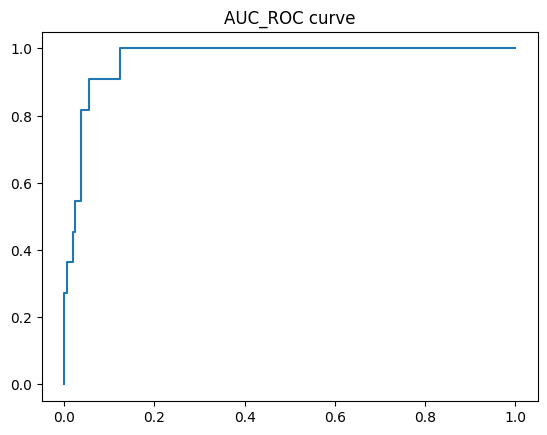

In [ ]:
#test
test(test_x,test_y,rf_model)

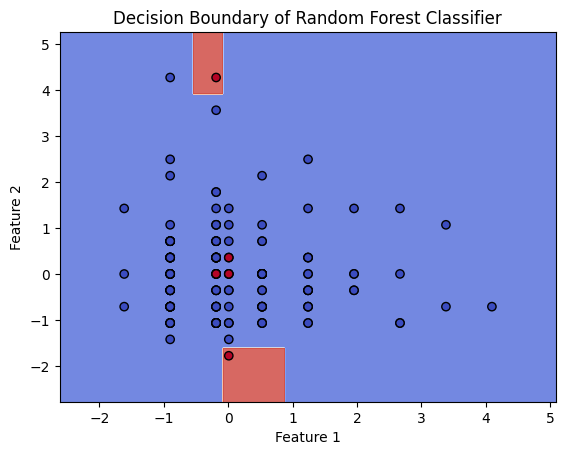

In [ ]:
# Plotting decision boundaries
two_features = test_x[:, [3, 2]]
plot_decision_boundary(two_features,test_y,rf_model)

Average scores across the 5 folds Accuracy: 0.9592087168094785, Precison: 0.6592352092352092, Recall : 0.7527777777777778 , F1_score:0.6955555555555556 


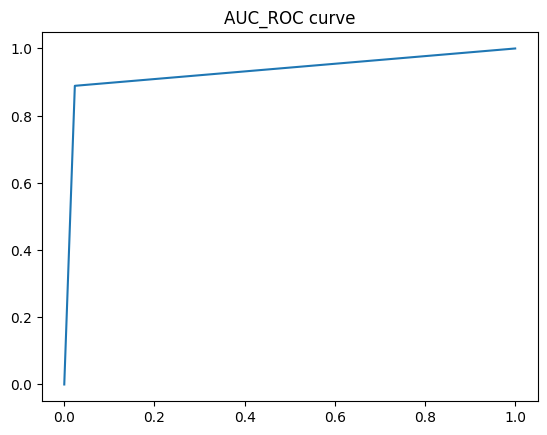

In [ ]:
dt = DecisionTreeClassifier(random_state = 67)
criterion = ['gini', 'entropy']
max_depth = [2,4,6,8,10,12]
parameters = dict(criterion=criterion, max_depth=max_depth)
clf_dt = GridSearchCV(dt, param_grid = parameters, scoring = 'accuracy', cv = 10)
clf_dt.fit(train_x, train_y)
dt_model = DecisionTreeClassifier(criterion = clf_dt.best_params_["criterion"], max_depth = clf_dt.best_params_["max_depth"])
dt_model = train_5_fold_validate(train_x,train_y,dt_model)

Scores on the test data Accuracy: 0.9709302325581395 Precison: 0.7142857142857143, Recall : 0.9090909090909091 , F1_score:0.8 


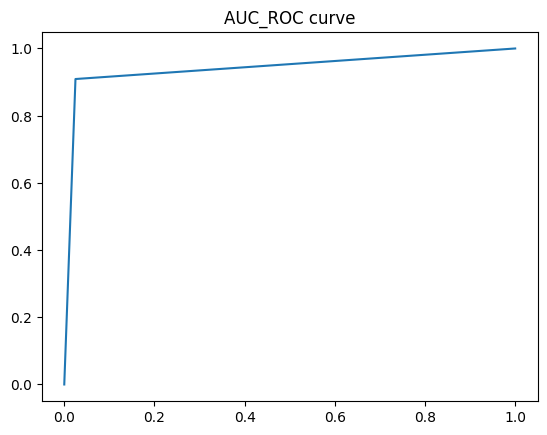

In [ ]:
#test
test(test_x,test_y,dt_model)

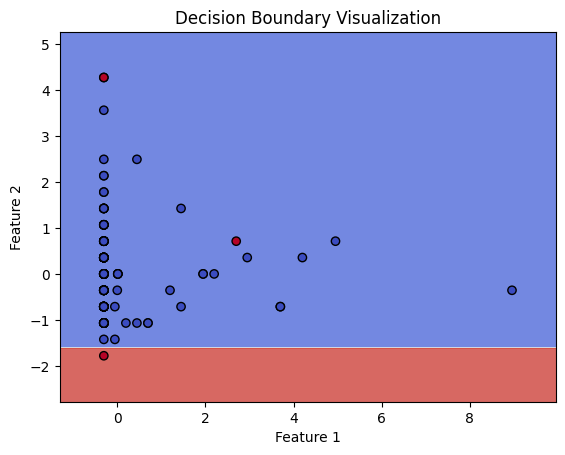

In [ ]:
# Plotting decision boundaries
two_features = test_x[:, [5, 2]]
plot_decision_boundary(two_features,test_y,dt_model)

Average scores across the 5 folds Accuracy: 0.9548079974611234, Precison: 0.6961111111111111, Recall : 0.5694444444444444 , F1_score:0.6162464985994399 


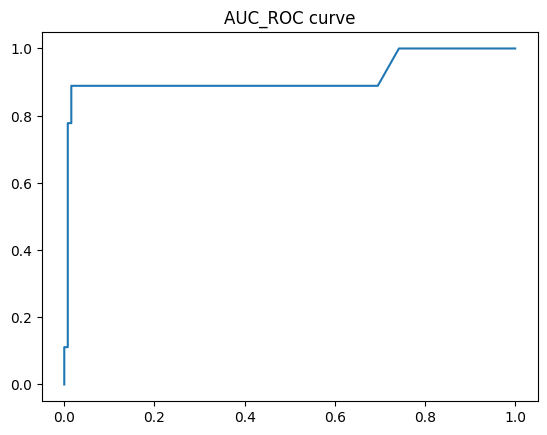

In [ ]:
param_grid = [{'estimator':[DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=2),DecisionTreeClassifier(max_depth=3)],'n_estimators':[40,50,60,70],'algorithm':['SAMME','SAMME.R']}]
classifification_model_obj = GridSearchCV(estimator = AdaBoostClassifier(random_state = 52),param_grid = param_grid,scoring = 'accuracy',refit=True).fit(train_x,train_y)
classifification_model_not_fitted = classifification_model_obj.best_estimator_
ada_boost_model = classifification_model_obj.best_estimator_
ada_boost_model = train_5_fold_validate(train_x,train_y,ada_boost_model)

Scores on the test data Accuracy: 0.9767441860465116 Precison: 0.8888888888888888, Recall : 0.7272727272727273 , F1_score:0.7999999999999999 


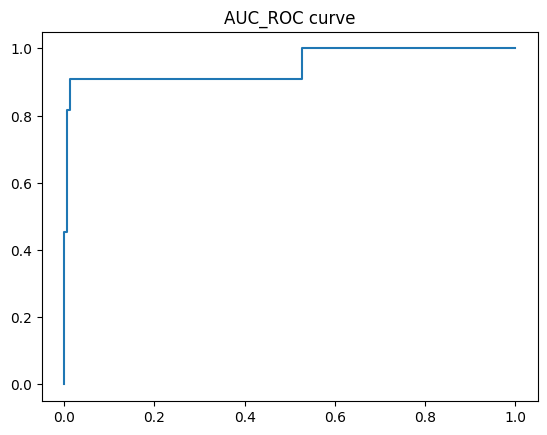

In [ ]:
#test
test(test_x,test_y,ada_boost_model)

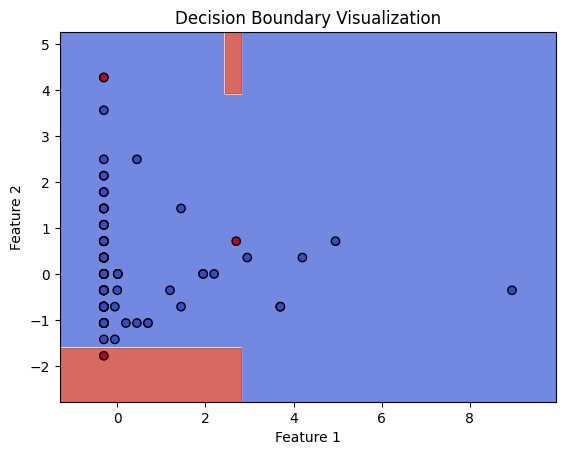

In [ ]:
# Plotting decision boundaries
two_features = test_x[:, [5, 2]]
plot_decision_boundary(two_features,test_y,ada_boost_model)

Average scores across the 5 folds Accuracy: 0.9504601713741669, Precison: 0.5800000000000001, Recall : 0.5944444444444444 , F1_score:0.5736842105263157 


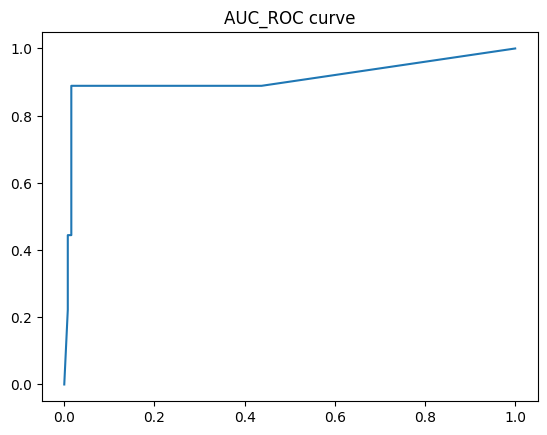

In [ ]:
param_grid = [{'reg_lambda':[0.001,0.1, 1,10,100],'max_depth':[6,10,14,18],"n_estimators":[80,120,140]}]
classifification_model_obj = GridSearchCV(estimator = xgboost.XGBClassifier(random_state = 62),param_grid = param_grid,scoring = 'accuracy',refit=True).fit(train_x,train_y)
classifification_model_not_fitted = classifification_model_obj.best_estimator_
xg_boost = classifification_model_obj.best_estimator_
xg_boost = train_5_fold_validate(train_x,train_y,xg_boost)

Scores on the test data Accuracy: 0.9709302325581395 Precison: 0.8, Recall : 0.7272727272727273 , F1_score:0.761904761904762 


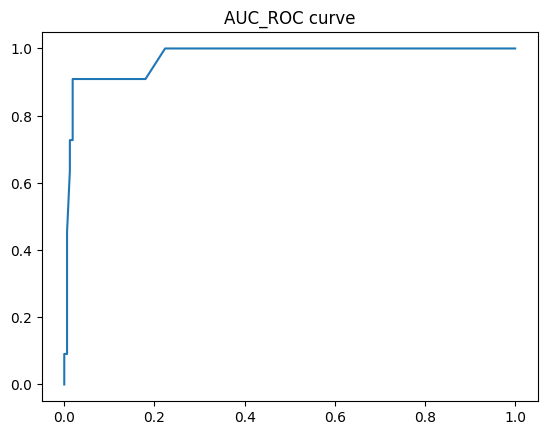

In [ ]:
#test
test(test_x,test_y,xg_boost)

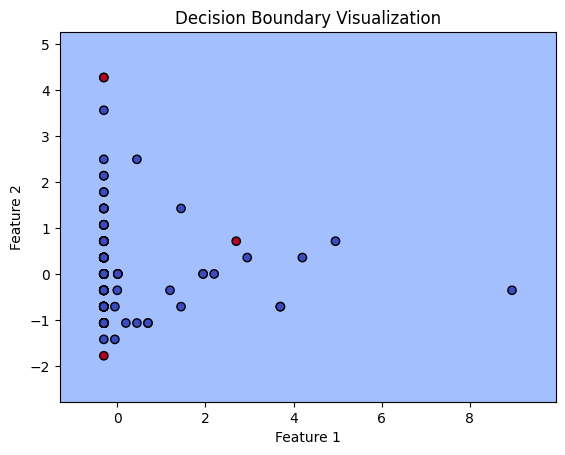

In [ ]:
# Plotting decision boundaries
two_features = test_x[:, [5, 2]]
plot_decision_boundary(two_features,test_y,xg_boost)

In [ ]:
train_x, train_y, test_x, test_y = split_and_normalise(dataset2,"fetal_health")
train_y -=1
test_y -=1
y_train_bin = np.where(train_y == 2, 1, train_y)
y_test_bin = np.where(test_y == 2, 1, test_y)

Average scores across the 5 folds Accuracy: 0.9562529137587822, Precison: 0.929220836552257, Recall : 0.7696114708603146 , F1_score:0.8408480690357194 


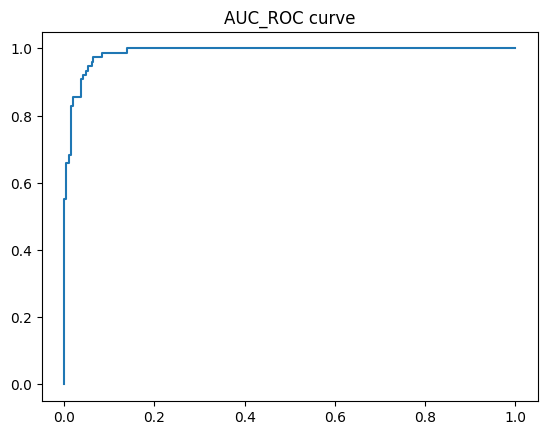

In [ ]:
#train
param_grid = [{'criterion':["gini", "entropy"],'max_depth':[6,8,10,12,14,16,18],"n_estimators":[80,100,120,140]}]
classifification_model_obj = GridSearchCV(estimator = RandomForestClassifier(random_state = 62),param_grid = param_grid,scoring = 'accuracy',refit=True).fit(train_x,train_y)
classifification_model_not_fitted = classifification_model_obj.best_estimator_
rf_model = classifification_model_obj.best_estimator_
bin_model = classifification_model_obj.best_estimator_
rf_model,bin_model = train_5_fold_validate_2(train_x,train_y,y_train_bin,rf_model,bin_model)

Scores on the test data Accuracy: 0.9514066496163683 Precison: 0.9, Recall : 0.7627118644067796 , F1_score:0.8256880733944953 


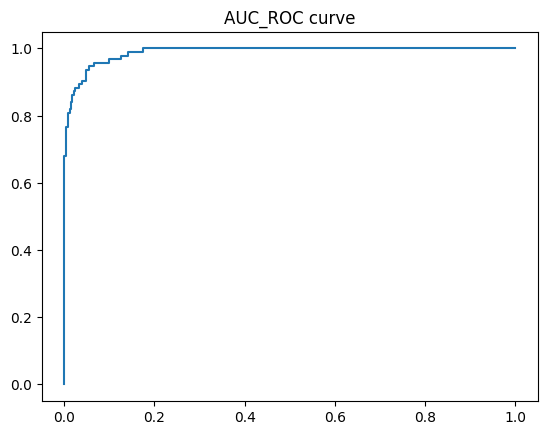

In [ ]:
#test
test_2(test_x,test_y,y_test_bin,rf_model,bin_model)

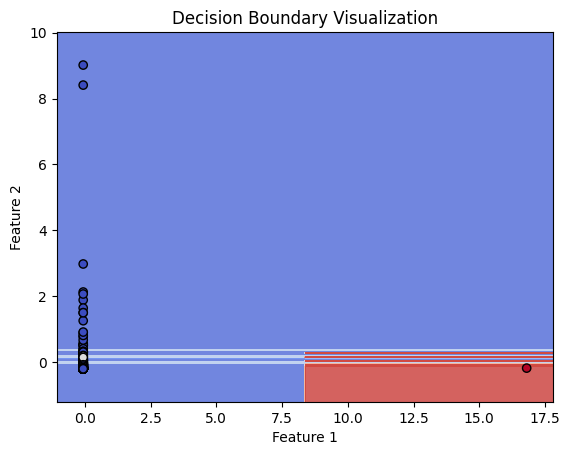

In [ ]:
# Plotting decision boundaries
two_features = test_x[:, [5, 2]]
plot_decision_boundary(two_features,test_y,rf_model)

Average scores across the 5 folds Accuracy: 0.9334447085433618, Precison: 0.7871090233728315, Recall : 0.7668414019940385 , F1_score:0.7744072626941677 


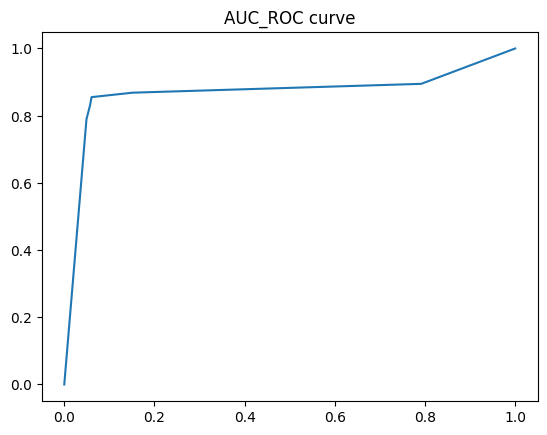

In [ ]:
dt = DecisionTreeClassifier(random_state = 67)
criterion = ['gini', 'entropy']
max_depth = [2,4,6,8,10,12]
parameters = dict(criterion=criterion, max_depth=max_depth)
clf_dt = GridSearchCV(dt, param_grid = parameters, scoring = 'accuracy')
clf_dt.fit(train_x, train_y)
dt_model = DecisionTreeClassifier(criterion = clf_dt.best_params_["criterion"], max_depth = clf_dt.best_params_["max_depth"])
bin_model = DecisionTreeClassifier(criterion = clf_dt.best_params_["criterion"], max_depth = clf_dt.best_params_["max_depth"])
dt_model,bin_model = train_5_fold_validate_2(train_x,train_y,y_train_bin,dt_model,bin_model)

Scores on the test data Accuracy: 0.9203084832904884 Precison: 0.7592592592592593, Recall : 0.6949152542372882 , F1_score:0.7256637168141593 


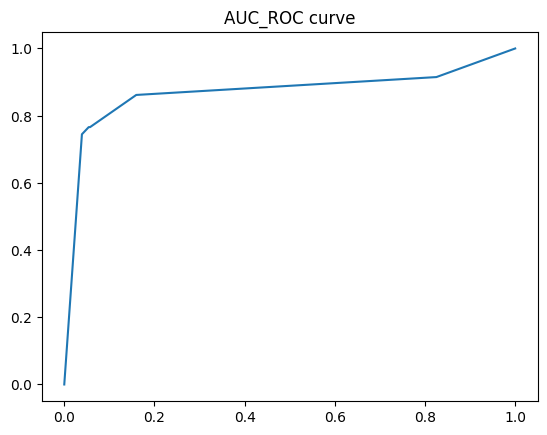

In [ ]:
#test
test_2(test_x,test_y,y_test_bin,dt_model,bin_model)

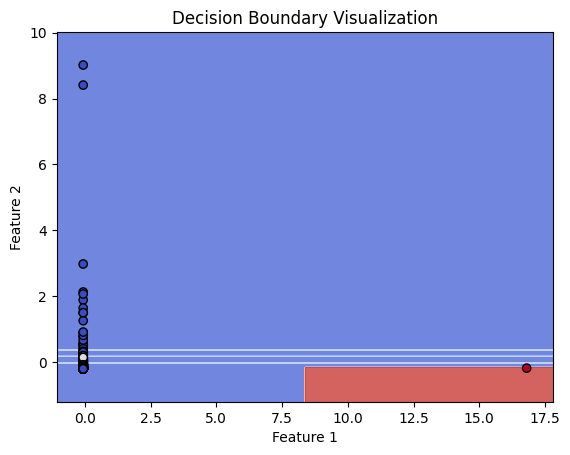

In [ ]:
# Plotting decision boundaries
two_features = test_x[:, [5, 2]]
plot_decision_boundary(two_features,test_y,bin_model)

Average scores across the 5 folds Accuracy: 0.9433935063657085, Precison: 0.8178481117605605, Recall : 0.8084798026518657 , F1_score:0.8121586350157779 


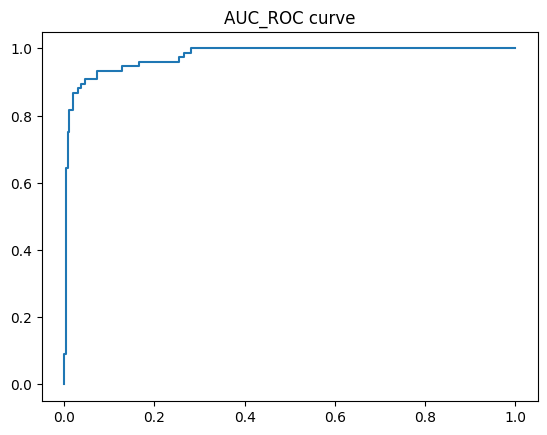

In [ ]:
param_grid = [{'estimator':[DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=2),DecisionTreeClassifier(max_depth=3)],'n_estimators':[40,50,60,70],'algorithm':['SAMME','SAMME.R']}]
classifification_model_obj = GridSearchCV(estimator = AdaBoostClassifier(random_state = 52),param_grid = param_grid,scoring = 'accuracy',refit=True).fit(train_x,train_y)
classifification_model_not_fitted = classifification_model_obj.best_estimator_
ada_boost_model = classifification_model_obj.best_estimator_
bin_model = classifification_model_obj.best_estimator_
ada_boost_model,bin_model = train_5_fold_validate_2(train_x,train_y,y_train_bin,ada_boost_model,bin_model)

Scores on the test data Accuracy: 0.9539641943734015 Precison: 0.9019607843137255, Recall : 0.7796610169491526 , F1_score:0.8363636363636364 


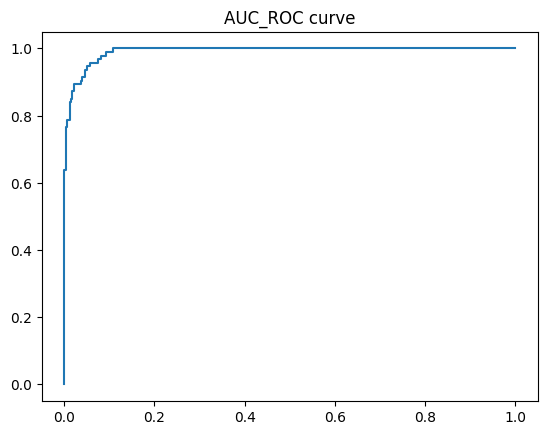

In [ ]:
#test
test_2(test_x,test_y,y_test_bin,ada_boost_model,bin_model)

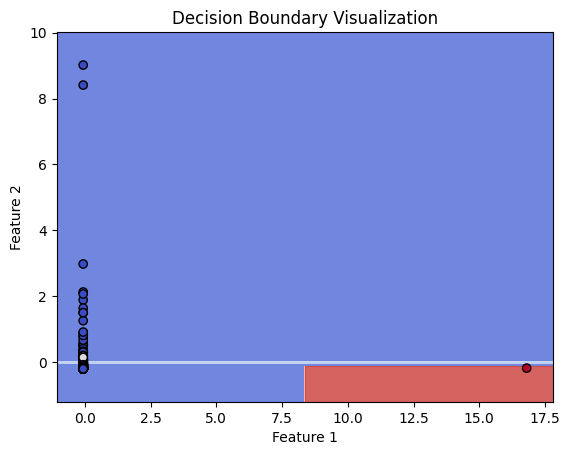

In [ ]:
# Plotting decision boundaries
two_features = test_x[:, [5, 2]]
plot_decision_boundary(two_features,test_y,ada_boost_model)

Average scores across the 5 folds Accuracy: 0.9632749925718921, Precison: 0.9089766290989502, Recall : 0.8427035152636447 , F1_score:0.874108364753526 


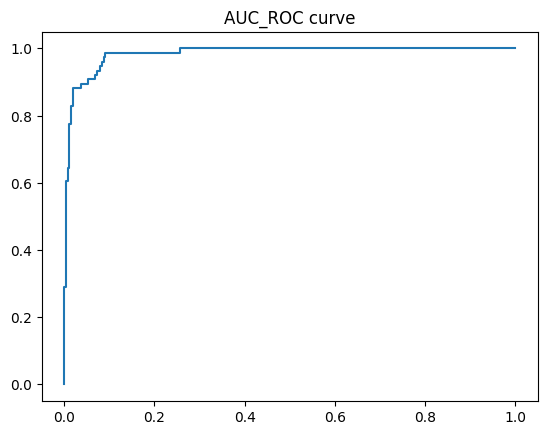

In [ ]:
param_grid = [{'reg_lambda':[0.001, 0.01, 0.1, 1,10],'max_depth':[6,10,14,18],"n_estimators":[80,120,140],"num_class":[1]}]
classifification_model_obj = GridSearchCV(estimator = xgboost.XGBClassifier(random_state = 62),param_grid = param_grid,scoring = 'accuracy',refit=True).fit(train_x,train_y)
classifification_model_not_fitted = classifification_model_obj.best_estimator_
xg_boost = classifification_model_obj.best_estimator_
bin_model = xgboost.XGBClassifier(random_state = 62,num_class =1)
xg_boost,bin_model = train_5_fold_validate_2(train_x,train_y,y_train_bin,xg_boost,bin_model)

Scores on the test data Accuracy: 0.9536082474226805 Precison: 0.8846153846153846, Recall : 0.7931034482758621 , F1_score:0.8363636363636363 


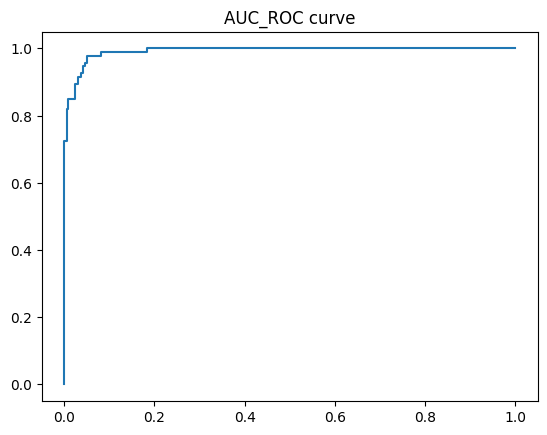

In [ ]:
#test
test_2(test_x,test_y,y_test_bin,xg_boost,bin_model)

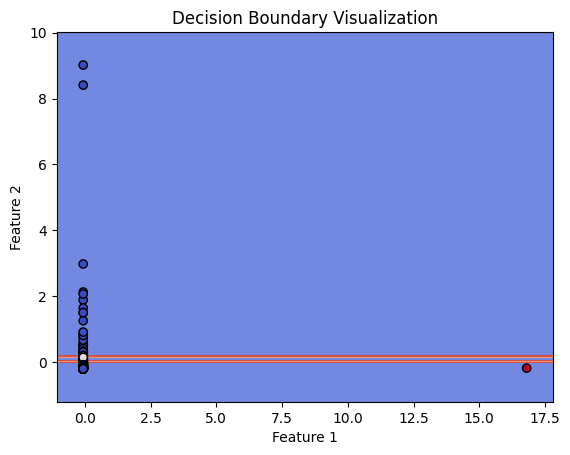

In [ ]:
# Plotting decision boundaries
two_features = test_x[:, [5, 2]]
plot_decision_boundary(two_features,test_y,xg_boost)

In [ ]:
categorical_columns = dataset3.select_dtypes(include=['object']).columns
dataset3 = pd.get_dummies(dataset3, columns=categorical_columns)


In [ ]:
train_x, train_y, test_x, test_y = split_and_normalise(dataset3,"y")

Average scores across the 5 folds Accuracy: 0.9116843702579667, Precison: 0.6699718446197582, Recall : 0.4253804602162864 , F1_score:0.5202720601895694 


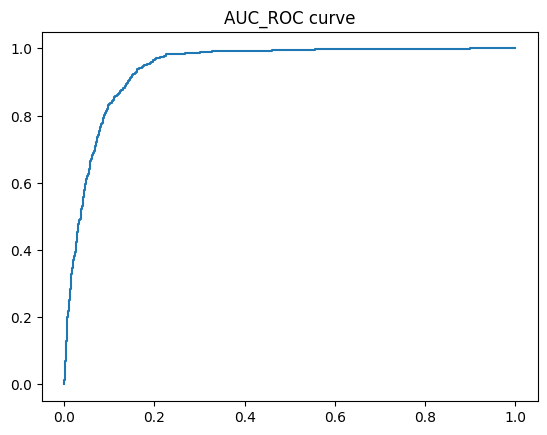

In [ ]:
#train
param_grid = [{'criterion':["gini", "entropy"],'max_depth':[6,10,14,18],"n_estimators":[80,120,140]}]
classifification_model_obj = GridSearchCV(estimator = RandomForestClassifier(random_state = 62),param_grid = param_grid,scoring = 'accuracy',refit=True).fit(train_x,train_y)
classifification_model_not_fitted = classifification_model_obj.best_estimator_
rf_model = classifification_model_obj.best_estimator_
rf_model = train_5_fold_validate(train_x,train_y,rf_model)

Scores on the test data Accuracy: 0.9150279193979121 Precison: 0.6868852459016394, Recall : 0.4515086206896552 , F1_score:0.5448634590377114 


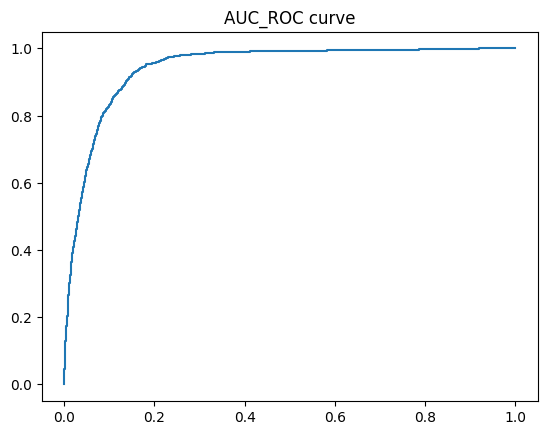

In [ ]:
#test
test(test_x,test_y,rf_model)

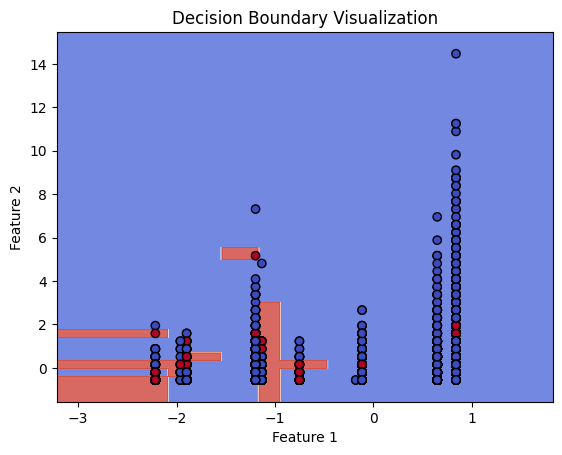

In [ ]:
# Plotting decision boundaries
two_features = test_x[:, [5, 2]]
plot_decision_boundary(two_features,test_y,rf_model)

Average scores across the 5 folds Accuracy: 0.9134749620637329, Precison: 0.6510295213037104, Recall : 0.4992037090109667 , F1_score:0.5644962244793424 


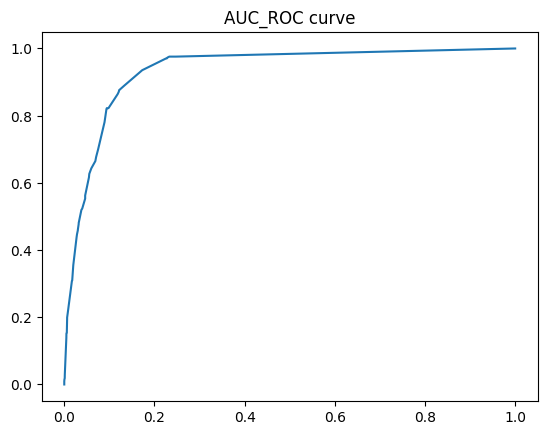

In [ ]:
dt = DecisionTreeClassifier(random_state = 67)
criterion = ['gini', 'entropy']
max_depth = [2,4,6,8,10,12]
parameters = dict(criterion=criterion, max_depth=max_depth)
clf_dt = GridSearchCV(dt, param_grid = parameters, scoring = 'accuracy', cv = 10)
clf_dt.fit(train_x, train_y)
dt_model = DecisionTreeClassifier(criterion = clf_dt.best_params_["criterion"], max_depth = clf_dt.best_params_["max_depth"])
dt_model = train_5_fold_validate(train_x,train_y,dt_model)

Scores on the test data Accuracy: 0.9140568099053168 Precison: 0.6598837209302325, Recall : 0.4892241379310345 , F1_score:0.5618811881188119 


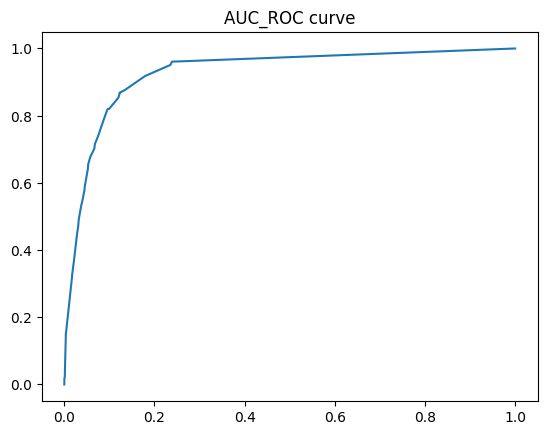

In [ ]:
#test
test(test_x,test_y,dt_model)

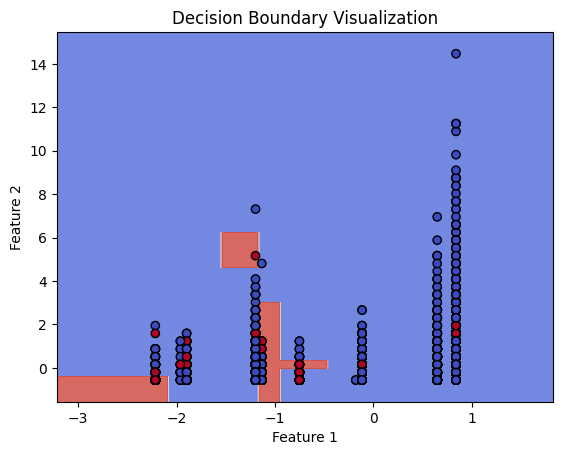

In [ ]:
# Plotting decision boundaries
two_features = test_x[:, [5, 2]]
plot_decision_boundary(two_features,test_y,dt_model)

Average scores across the 5 folds Accuracy: 0.9133839150227617, Precison: 0.6435237843683052, Recall : 0.5188584923799124 , F1_score:0.5744230143466561 


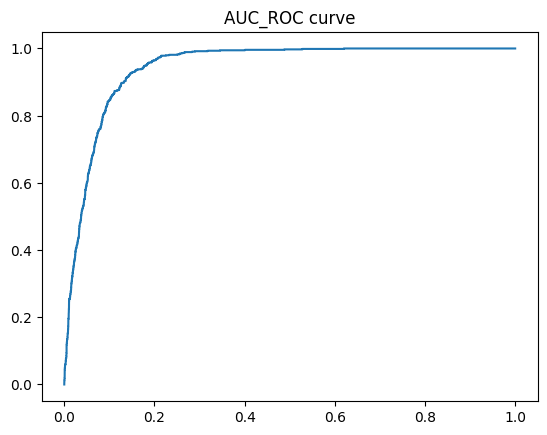

In [ ]:
param_grid = [{'estimator':[DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=2),DecisionTreeClassifier(max_depth=3)],'n_estimators':[40,50,60,70],'algorithm':['SAMME','SAMME.R']}]
classifification_model_obj = GridSearchCV(estimator = AdaBoostClassifier(random_state = 52),param_grid = param_grid,scoring = 'accuracy',refit=True).fit(train_x,train_y)
classifification_model_not_fitted = classifification_model_obj.best_estimator_
ada_boost_model = classifification_model_obj.best_estimator_
ada_boost_model = train_5_fold_validate(train_x,train_y,ada_boost_model)

Scores on the test data Accuracy: 0.91442097596504 Precison: 0.6500672947510094, Recall : 0.5204741379310345 , F1_score:0.5780969479353679 


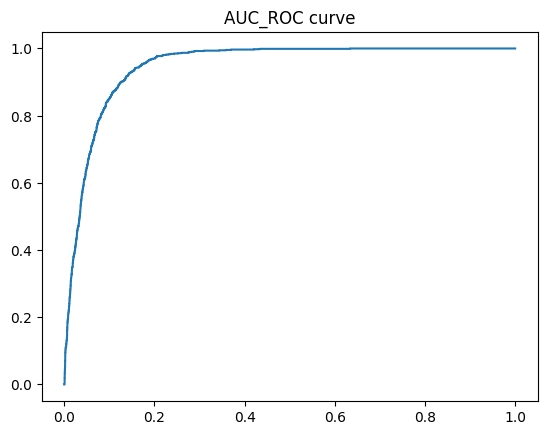

In [ ]:
#test
test(test_x,test_y,ada_boost_model)

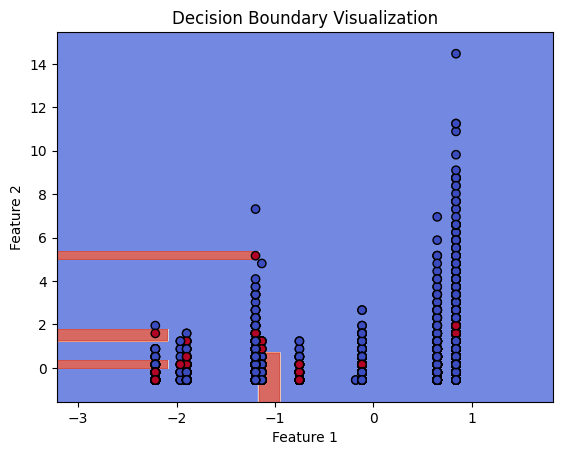

In [ ]:
# Plotting decision boundaries
two_features = test_x[:, [5, 2]]
plot_decision_boundary(two_features,test_y,ada_boost_model)

Average scores across the 5 folds Accuracy: 0.9157207890743552, Precison: 0.651513385273202, Recall : 0.5412290089351467 , F1_score:0.59111156753261 


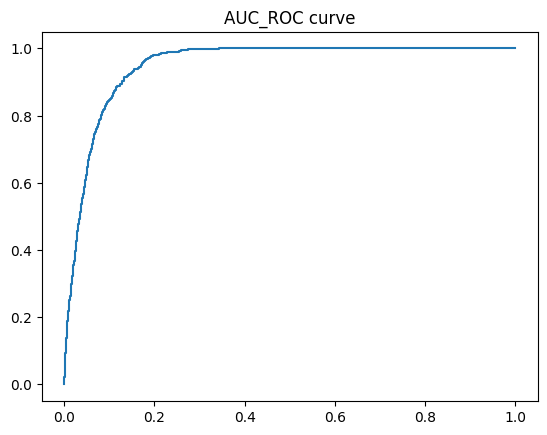

In [ ]:
param_grid = [{'reg_lambda':[0.001,0.1, 1,10,100],'max_depth':[6,10,14,18],"n_estimators":[80,120,140]}]
classifification_model_obj = GridSearchCV(estimator = xgboost.XGBClassifier(random_state = 62),param_grid = param_grid,scoring = 'accuracy',refit=True).fit(train_x,train_y)
classifification_model_not_fitted = classifification_model_obj.best_estimator_
xg_boost = classifification_model_obj.best_estimator_
xg_boost = train_5_fold_validate(train_x,train_y,xg_boost)

Scores on the test data Accuracy: 0.9180626365622724 Precison: 0.6583229036295369, Recall : 0.5668103448275862 , F1_score:0.6091488129704691 


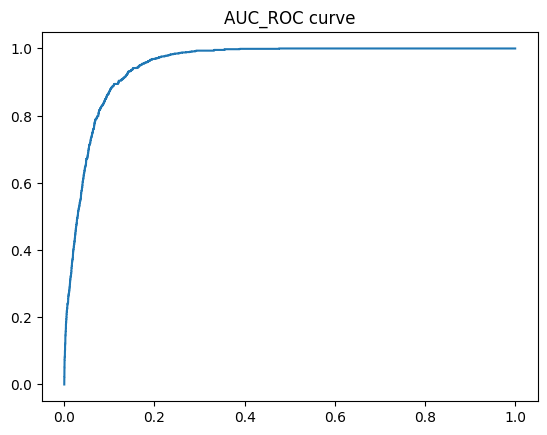

In [ ]:
#test
test(test_x,test_y,xg_boost)

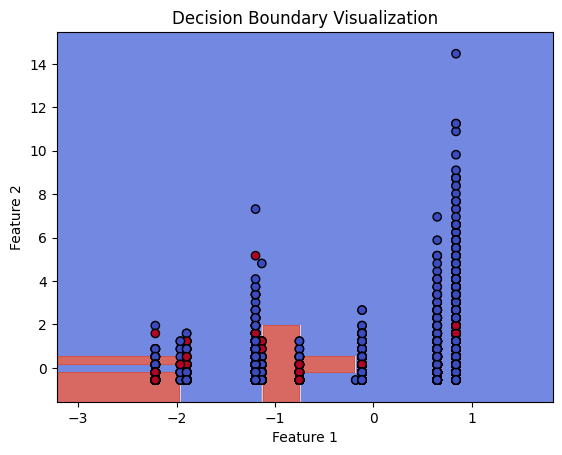

In [ ]:
# Plotting decision boundaries
two_features = test_x[:, [5, 2]]
plot_decision_boundary(two_features,test_y,xg_boost)